In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
import nibabel as nib
from sklearn.model_selection import LeaveOneOut
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
from scipy.stats import pearsonr
import numpy as np

In [27]:

def normalize_time_series(time_series):

    time_series = np.array(time_series)
    mean = np.mean(time_series)
    std = np.std(time_series)
    
    # Avoid division by zero if the std is zero
    if std == 0:
        return time_series - mean
    
    return (time_series - mean) / std
def fisher_r_to_z(correlation_coefficient):
    # Convert the input to a numpy array
    correlation_coefficient = np.array(correlation_coefficient)
    
    # Apply Fisher r-to-z transformation
    return 0.5 * np.log((1 + correlation_coefficient) / (1 - correlation_coefficient))



def partial_correlation(MVC_scores,connectomes,covariates):
    covariates=sm.add_constant(covariates)
    MVC_scores=np.array(MVC_scores, dtype=np.float64)
    covariates=np.array(covariates, dtype=np.float64)
    model_mvc=sm.OLS(MVC_scores,covariates).fit()
    mvc_residuals=model_mvc.resid
    n_features = connectomes.shape[1]
    partial_corrs = np.zeros(n_features)
    p_values = np.zeros(n_features)
    for i in range(n_features):
        feature = connectomes[:, i]
        model_feature = sm.OLS(feature, covariates).fit()
        feature_residuals = model_feature.resid
        
        # Calculate Pearson correlation between the residuals
        partial_corrs[i], p_values[i] = pearsonr(mvc_residuals, feature_residuals)
    return partial_corrs, p_values

def select_features_1d(corrs,pvals,pval_threshold):
    pos_fets_whole=np.zeros_like(corrs)
    neg_fets_whole=np.zeros_like(corrs)
    for i in range(corrs.shape[0]):
        if pvals[i]<pval_threshold:
            if corrs[i]>0:
                pos_fets_whole[i]=1
            elif corrs[i]<0:
                neg_fets_whole[i]=1
    selected_pos_features=np.where(pos_fets_whole>=pval_threshold)
    selected_neg_features=np.where(neg_fets_whole>=pval_threshold)
    return selected_neg_features,selected_pos_features

def select_features(corrs,pvals,pval_threshold,fraction_of_within_threshold_subs):
    num_samples=corrs.shape[1]
    pos_fets_whole=np.zeros_like(corrs)
    neg_fets_whole=np.zeros_like(corrs)
    for i in range(corrs.shape[0]):
        for j in range(corrs.shape[1]):
            if pvals[i,j]<pval_threshold:
                if corrs[i,j]>0:
                    pos_fets_whole[i,j]=1
                elif corrs[i,j]<0:
                    neg_fets_whole[i,j]=1
    pos_fets=np.sum(pos_fets_whole,axis=1)
    neg_fets=np.sum(neg_fets_whole,axis=1)
    acceptance_threshold=int(fraction_of_within_threshold_subs*num_samples)
    selected_pos_features=np.where(pos_fets>=acceptance_threshold)
    selected_neg_features=np.where(neg_fets>=acceptance_threshold)
    selected_neg_features=np.array(selected_neg_features).reshape(-1)
    selected_pos_features=np.array(selected_pos_features).reshape(-1)
    return selected_neg_features,selected_pos_features



from sklearn.linear_model import LinearRegression
def linear_model_builder(fets_model,mvc_model,cov,selected_features):
    
    connectomes=fets_model[:,selected_features]
    connectomes=np.hstack((connectomes,cov))
    print(len(selected_features))
    print(np.shape(connectomes))
    model=LinearRegression()  
    model.fit(connectomes,mvc_model)
    return model

import numpy as np
import statsmodels.api as sm

def recognize_covariate_effect(data, covariate):
    # Ensure inputs are numpy arrays
    data = np.array(data,dtype=np.float64)
    covariate = np.array(covariate,dtype=np.float64)

    
    # Add a constant term for the intercept in linear regression
    covariate_with_intercept = sm.add_constant(covariate)
    
    # Fit a linear regression model
    model = sm.OLS(data, covariate_with_intercept).fit()
    
    # Get the residuals (data with the effect of the covariate removed)
    residuals = model.resid
    
    return residuals, model


def remove_covariate_effect(model,data,covariate):
    temp1=sm.add_constant(covariate)
    if len(temp1)==1:
        temp1=np.concatenate((np.ones((len(temp1),1)),temp1),axis=1)
    temp=model.predict(temp1)
    data=data-temp
    return data


def corr_pval(fp, scores,features, n_jobs=-1):  # n_jobs=-1 uses all available cores
    num_samples=len(fp)
    states_length=len(fp[0])
    corrs = np.zeros((states_length, num_samples))
    pvals = np.zeros((states_length, num_samples))
    for i in range(states_length):
        if i not in features:
            corrs[i,:]=0
            pvals[i,:]=1

    def compute_corr_pval(ii, X_train, y_train, test_index):
        # if ii % 10000 == 0:
        #     print(f"Looking at feature {ii}")
        corr, pval = pearsonr(X_train[:, ii], y_train)
        return (ii, test_index, corr, pval)

    for train_index, test_index in loo.split(fp):
        X_train, X_test = fp[train_index], fp[test_index]
        y_train, y_test = scores[train_index], scores[test_index]

        # if test_index % 100 == 0:
        # print(f"Currently the test index is {test_index}")
        
        # Use Parallel to parallelize over the features (ii loop)
        results = Parallel(n_jobs=n_jobs)(delayed(compute_corr_pval)(ii, X_train, y_train, test_index)
                                          for ii in features)

        # Gather results
        for ii, test_index, corr, pval in results:
            corrs[ii, test_index] = corr
            pvals[ii, test_index] = pval

    return corrs, pvals

def compute_feature_corrs(fet, in_train_random, out_train_random):
    return pearsonr(in_train_random[:, fet], out_train_random)

def order_output_with_interval(input,interval):
    input_in_order=np.argsort(input)
    indices_order=np.concatenate([np.arange(i,len(input),interval) for i in range(interval)])
    new_order_of_indices=input_in_order[indices_order]
    return new_order_of_indices

def normalize_features(train, test):
    return (
        (train - train.min(axis=0)) / (train.max(axis=0) - train.min(axis=0)),
        (test - train.min(axis=0)) / (train.max(axis=0) - train.min(axis=0))
    )

def best_stable_num_features(corrcoef_vec):
    diffs=np.abs(np.diff(corrcoef_vec))
    threshold=np.percentile(diffs,25)
    stable_idx=np.where(diffs<threshold)[0][0]+1
    max_ind=np.argmax(corrcoef_vec[stable_idx:])
    return max_ind+stable_idx



def give_me_bootstrap_fraction(bootstrapp_fractions,num_iterations):
    div_res=num_iterations//len(bootstrapp_fractions)
    bootstrap_choices=[]
    for i , fraction in enumerate(bootstrapp_fractions):
        bootstrap_choices.extend([fraction]*div_res)
    remainder=num_iterations%len(bootstrapp_fractions)
    bootstrap_choices.extend(bootstrapp_fractions[:remainder])
    return bootstrap_choices


In [3]:
fingerprints_dir="/home/aghaffari/lcaging_fmri/isbi_2025_fcn/fingerprints"
fp_list=os.listdir(fingerprints_dir)
fp_list=[x for x in fp_list if "conn" in x]
fp_indices=[x[-10:-7] for x in fp_list]
fp_indices=np.unique(fp_indices)
isbi_dir="/home/aghaffari/lcaging_fmri/isbi_2025_fcn"
excel_sheet="LC Aging Subject Data master spreadsheet.xlsx"
sheet=pd.read_excel(os.path.join(isbi_dir,excel_sheet), sheet_name="neuropsych")
demographics_sheet=pd.read_excel(os.path.join(isbi_dir,excel_sheet), sheet_name="demographics")
mvc_data=sheet[['SUBJECT NUMBER','In Scanner MVC S2','In Scanner MVC S3','Workroom MVC S1','Workroom MVC S2','Workroom MVC S3','Visual Session']]
demographics_data=demographics_sheet[['SUBJECT NUMBER_1',"SEX","AGE AT BAP SESSION 1"]]
final_df=pd.DataFrame(columns=['SUBJECT NUMBER','Visual Session','Workroom MVC S1','Workroom MVC S2','Workroom MVC S3','sex','age'])
mvc_sub_list=mvc_data['SUBJECT NUMBER'].str[-3:].tolist()
demographics_sub_list=demographics_data['SUBJECT NUMBER_1'].str[-3:].tolist()
k=0
for ii in range(len(fp_indices)):
    ## find the row in the mvc data that contains the current subject number
    curr_sub_id=fp_indices[ii]
    if (curr_sub_id not in mvc_sub_list):
        print("The current subject is not in the mvc data: ",curr_sub_id)
        continue
    else:
        mvc_ind=mvc_sub_list.index(curr_sub_id)
        current_row_mvc=mvc_data.iloc[mvc_ind]
        final_df.loc[k,'SUBJECT NUMBER']=current_row_mvc['SUBJECT NUMBER']
        final_df.loc[k,'Visual Session']=current_row_mvc['Visual Session']
        final_df.loc[k,'Workroom MVC S1']=current_row_mvc['Workroom MVC S1']
        final_df.loc[k,'Workroom MVC S2']=current_row_mvc['Workroom MVC S2']
        final_df.loc[k,'Workroom MVC S3']=current_row_mvc['Workroom MVC S3']
        k=k+1

k=0
for mio in range(len(final_df)):
    curr_sub_id=final_df.iloc[mio]['SUBJECT NUMBER'][-3:]
    if curr_sub_id in demographics_sub_list:
        demographics_ind=demographics_sub_list.index(curr_sub_id)
        current_row_demographics=demographics_data.iloc[demographics_ind]
        final_df.loc[k,'sex']=current_row_demographics['SEX']
        final_df.loc[k,'age']=current_row_demographics['AGE AT BAP SESSION 1']
        k=k+1
    if curr_sub_id=='136':
        final_df.loc[k,'sex']=current_row_demographics['SEX']='Female'
        final_df.loc[k,'age']=current_row_demographics['AGE AT BAP SESSION 1']=72
        k=k+1

for ii in range(len(final_df)):
    current_row=final_df.iloc[ii]
    #if current_row['Workroom MVC S1'] is a nan:
    mio=0
    if pd.isnull(current_row['Workroom MVC S2']):
        mio=mio+1
        empty='Workroom MVC S2'
        nonempty='Workroom MVC S3'
    if pd.isnull(current_row['Workroom MVC S3']):
        mio=mio+1
        empty='Workroom MVC S3'
        nonempty='Workroom MVC S2'
    if ((mio==1)&(pd.isnull(current_row['Workroom MVC S1'])==False)):
        final_df.loc[ii,empty]=(current_row['Workroom MVC S1']+current_row[nonempty])/2
    if ((mio==2)&(pd.isnull(current_row['Workroom MVC S1'])==False)):
        final_df.loc[ii,'Workroom MVC S2']=current_row['Workroom MVC S1']
        final_df.loc[ii,'Workroom MVC S3']=current_row['Workroom MVC S1']
        
    print("for subject number: ",current_row['SUBJECT NUMBER'],"the mvcs are nan: ",mio)
        
## drop the Nan having rows from the final_df
final_df=final_df.dropna()
final_list=final_df['SUBJECT NUMBER'].str[-3:].tolist()
final_fp_indices=[x for x in fp_indices if x in final_list]


for subject number:  BAP003 the mvcs are nan:  0
for subject number:  BAP102 the mvcs are nan:  0
for subject number:  BAP103 the mvcs are nan:  0
for subject number:  BAP104 the mvcs are nan:  0
for subject number:  BAP106 the mvcs are nan:  0
for subject number:  BAP107 the mvcs are nan:  0
for subject number:  BAP108 the mvcs are nan:  0
for subject number:  BAP110 the mvcs are nan:  0
for subject number:  BAP111 the mvcs are nan:  0
for subject number:  BAP114 the mvcs are nan:  0
for subject number:  BAP116 the mvcs are nan:  0
for subject number:  BAP117 the mvcs are nan:  0
for subject number:  BAP118 the mvcs are nan:  0
for subject number:  BAP120 the mvcs are nan:  0
for subject number:  BAP121 the mvcs are nan:  0
for subject number:  BAP123 the mvcs are nan:  0
for subject number:  BAP124 the mvcs are nan:  0
for subject number:  BAP125 the mvcs are nan:  0
for subject number:  BAP128 the mvcs are nan:  0
for subject number:  BAP129 the mvcs are nan:  0
for subject number: 

/tmp/ipykernel_31234/2972056038.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.loc[k,'sex']=current_row_demographics['SEX']='Female'
/tmp/ipykernel_31234/2972056038.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.loc[k,'age']=current_row_demographics['AGE AT BAP SESSION 1']=72


In [4]:
## reading the input and output data
loo=LeaveOneOut()
sex=final_df['sex'].values
sex_binary=np.zeros(len(sex))
for ii in range(len(sex_binary)):
    if sex[ii]=="Male":
        sex_binary[ii]=1
age=final_df['age'].values
covariates=np.vstack((sex_binary,age)).T

sample_fp_add="/home/aghaffari/lcaging_fmri/isbi_2025_fcn/fingerprints/auditory_conn_117.pickle"
with open(sample_fp_add, 'rb') as f:
    sample_fp = pickle.load(f)

aud_fps=np.zeros((len(final_fp_indices),sample_fp.shape[0]))
vis_fps=np.zeros((len(final_fp_indices),sample_fp.shape[0]))


for (i,sub) in enumerate(final_fp_indices):
    aud_fp_add=os.path.join(fingerprints_dir,"auditory_conn_"+sub+".pickle")
    vis_fp_add=os.path.join(fingerprints_dir,"visual_conn_"+sub+".pickle")
    with open(aud_fp_add, 'rb') as f:
        aud_fp = pickle.load(f)
    with open(vis_fp_add, 'rb') as f:
        vis_fp = pickle.load(f)
    aud_fps[i,:]=aud_fp
    vis_fps[i,:]=vis_fp
# vis_mean=np.mean(vis_fps,axis=0)
# aud_mean=np.mean(aud_fps,axis=0)
## demean the fingerprints

mvc_ses1=np.array(final_df['Workroom MVC S1'].values)
mvc_ses2=np.array(final_df['Workroom MVC S2'].values)
mvc_ses3=np.array(final_df['Workroom MVC S3'].values)
mvc1=np.mean(np.vstack((mvc_ses1,mvc_ses2,mvc_ses3)),axis=0)

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
task="auditory"
if task=="visual":
    input_data1=vis_fps
elif task=="auditory":
    input_data1=aud_fps
num_folds=4
num_features=[5,10,20,50,60,70,75,80,90,100,120,150,175,200,225,250,275,300,350,400,500,600,700,800,900,1000,1200,1400,1420,1600,1800,2000]
predictions=np.zeros((len(final_fp_indices),len(num_features)))
reordered_output_args=order_output_with_interval(mvc1,num_folds)
mvc,cov,input_data=mvc1[reordered_output_args],covariates[reordered_output_args],input_data1[reordered_output_args]
folds=np.array_split(np.arange(len(final_fp_indices)),num_folds)
for fi,fold in enumerate(folds):
    print("fold number: ",fi)
    test_indices,train_indices=fold,np.setdiff1d(np.arange(len(final_fp_indices)),fold)
    x_train_i,y_train,x_test_i,y_test=input_data[train_indices],mvc[train_indices],input_data[test_indices],mvc[test_indices]
    x_train,x_test=np.zeros_like(x_train_i),np.zeros_like(x_test_i)
    x_train,x_test=normalize_features(x_train_i,x_test_i)
    ## remove covariate effect
    y_train, model = recognize_covariate_effect(y_train, cov[train_indices])
    y_test = remove_covariate_effect(model, y_test, cov[test_indices])
    corrs0,pvals0=np.zeros((len(x_train[0]))),np.zeros((len(x_train[0])))
    for feature in range(len(x_train[0])):
        corrs0[feature],pvals0[feature]=pearsonr(x_train[:,feature],y_train)
    neg0,pos0=select_features_1d(corrs0,pvals0,0.1)
    features_step1=np.concatenate((neg0[0],pos0[0]))
    num_random_iterations=100
    fractions=[0.4,0.5,0.6,0.7,0.8,0.9]
    corrs1,pvals1=np.zeros((len(x_train[0]),num_random_iterations)),np.ones((len(x_train[0]),num_random_iterations))
    for random_iteration in range(num_random_iterations):
        chosen_fraction=np.random.choice(fractions)
        num_samples=int(chosen_fraction*len(y_train))
        random_indices=np.random.choice(np.arange(len(y_train)),num_samples,replace=False)
        x_train_random,y_train_random=x_train[random_indices],y_train[random_indices]
        results=Parallel(n_jobs=-1)(delayed(compute_feature_corrs)(fet,x_train_random,y_train_random) for fet in features_step1)
        mieow=0
        for ft2 in features_step1:
            corrs1[ft2,random_iteration],pvals1[ft2,random_iteration]=results[mieow]
            mieow+=1
    corrs1_mean,pvals1_mean=np.mean(corrs1,axis=1),np.mean(pvals1,axis=1)
    features_sorted=np.argsort(pvals1_mean)
    pvals_sorted,corrs_sorted=pvals1_mean[features_sorted],corrs1_mean[features_sorted]
    for iff,num_feature in enumerate(num_features):
        selected_features=features_sorted[:num_feature]
        if iff==0:
            print(selected_features[:5])
        model=LinearRegression()
        model.fit(x_train[:,selected_features],y_train)
        predictions[test_indices,iff]=model.predict(x_test[:,selected_features])

fold number:  0
[18530 14717 15649 15610 22526]
fold number:  1
[13121 22526 13005 14717 14730]
fold number:  2
[17217 11969   417 17000 15579]
fold number:  3
[22526 13121 14717 18530 17217]


In [ ]:
row=30
plt.scatter(predictions[:,row],mvc)
print(pearsonr(predictions[:,row],mvc)) 
## plot the best fit line
model=LinearRegression()
model.fit(predictions[:,row].reshape(-1,1),mvc)
x=np.linspace(np.min( predictions[:,row]),np.max(predictions[:,row]),100)
y=model.predict(x.reshape(-1,1))
plt.plot(x,y,color='red')
plt.xlabel("Predictions")
plt.ylabel("True values")
corrcoef=np.round(pearsonr(mvc,predictions[:,row])[0],3)
pvalue=np.round(pearsonr(mvc,predictions[:,row])[1],3)
## add correlation coefficient and pvalue to the plot
plt.text(np.min(predictions[:,row]),np.min(mvc)+42000,"Correlation coefficient: "+str(corrcoef))
plt.text(np.min(predictions[:,row]),np.min(mvc)+39000,"P-value: "+str(pvalue))

In [63]:
def two_step_feature_selection(x_train, y_train, num_bootstrap_iterations, bootstrap_choices, corr_thresh, select_features_1d, compute_feature_corrs):
    """
    Performs feature selection using Pearson correlation and bootstrap resampling.

    Parameters:
        x_train (ndarray): Training data (samples x features).
        y_train (ndarray): Target variable.
        num_bootstrap_iterations (int): Number of bootstrap iterations.
        bootstrap_choices (list or ndarray): Fractions of data to sample for bootstrapping.
        corr_thresh (float): Threshold for selecting significant features.
        select_features_1d (function): Function to filter features based on correlation and p-values.
        compute_feature_corrs (function): Function to compute feature correlations.

    Returns:
        mean_corrs (ndarray): Mean correlation values across bootstraps.
        mean_pvals (ndarray): Mean p-values across bootstraps.
    """
    
    num_features = x_train.shape[1]
    
    # Step 1: Compute correlation and p-values for all features
    corrs = np.zeros(num_features, dtype=np.float64)
    pvals = np.zeros(num_features, dtype=np.float64)
    
    for feature in range(num_features):
        corrs[feature], pvals[feature] = pearsonr(x_train[:, feature], y_train)

    # Step 2: Select features based on correlation threshold
    neg_features, pos_features = select_features_1d(corrs, pvals, corr_thresh)
    selected_features = np.concatenate((neg_features[0], pos_features[0]))

    # Step 3: Initialize arrays to store bootstrapped correlations and p-values
    boot_corrs = np.zeros((num_features, num_bootstrap_iterations))
    boot_pvals = np.ones((num_features, num_bootstrap_iterations))

    # Step 4: Bootstrap sampling and parallelized correlation computation
    for bootstrap in range(num_bootstrap_iterations):
        chosen_fraction = bootstrap_choices[bootstrap]
        num_samples = int(chosen_fraction * len(y_train))
        random_indices = np.random.choice(np.arange(len(y_train)), num_samples, replace=False)
        x_train_random, y_train_random = x_train[random_indices], y_train[random_indices]

        # Compute correlations in parallel
        results = Parallel(n_jobs=-1)(delayed(compute_feature_corrs)(fet, x_train_random, y_train_random) for fet in selected_features)

        # Store results
        for idx, feature in enumerate(selected_features):
            boot_corrs[feature, bootstrap], boot_pvals[feature, bootstrap] = results[idx]

    # Step 5: Compute mean correlation and p-values across bootstraps
    mean_corrs = np.mean(boot_corrs, axis=1)
    mean_pvals = np.mean(boot_pvals, axis=1)

    return mean_corrs, mean_pvals

In [130]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
task="auditory"
if task=="visual":
    input_data1=vis_fps
elif task=="auditory":
    input_data1=aud_fps
num_outer_folds=4
num_inner_folds=3
num_features = list(range(10, 2001, 10))
reordered_output_args=order_output_with_interval(mvc1,num_outer_folds)
mvc,cov,input_data=mvc1[reordered_output_args],covariates[reordered_output_args],input_data1[reordered_output_args]
folds=np.array_split(np.arange(len(final_fp_indices)),num_outer_folds)
num_bootstrap_iterations=200
bootstrapping_fractions=[0.6,0.7,0.8,0.9]
bootstrap_choices=give_me_bootstrap_fraction(bootstrapping_fractions,num_bootstrap_iterations)
inner_corrcoef=np.zeros((num_outer_folds,len(num_features)))
fold_best_num_features=np.zeros(num_outer_folds)
predictions=np.zeros(len(final_fp_indices))
for fo,fold in enumerate(folds):
    print("fold number: ",fo)
    test_indices,train_indices=fold,np.setdiff1d(np.arange(len(final_fp_indices)),fold)
    x_train_i,y_train,x_test_i,y_test=input_data[train_indices],mvc[train_indices],input_data[test_indices],mvc[test_indices]
    x_train,x_test=np.zeros_like(x_train_i),np.zeros_like(x_test_i)
    x_train,x_test=normalize_features(x_train_i,x_test_i)
    ## remove covariate effect
    y_train, model = recognize_covariate_effect(y_train, cov[train_indices])
    y_test = remove_covariate_effect(model, y_test, cov[test_indices])
    inner_args_sorted=order_output_with_interval(y_train,num_inner_folds)
    inner_folds=np.array_split(np.arange(len(y_train)),num_inner_folds)
    y_inner,x_inner=y_train[inner_args_sorted],x_train[inner_args_sorted]
    inner_predictions=np.zeros((len(y_train),len(num_features)))
    for fi,inner_fold in enumerate(inner_folds):
        print("inner fold number: ",fi)
        in_train_indices,in_valid_indices=np.setdiff1d(np.arange(len(y_train)),inner_fold),inner_fold
        x_train_inner,y_train_inner,x_valid_inner,y_valid_inner=x_inner[in_train_indices],y_inner[in_train_indices],x_inner[in_valid_indices],y_inner[in_valid_indices]
        corrs1_mean_in,pvals1_mean_in=two_step_feature_selection(x_train_inner,y_train_inner,num_bootstrap_iterations,bootstrap_choices,0.1,select_features_1d,compute_feature_corrs)
        features_sorted_in=np.argsort(pvals1_mean_in)
        for iff,num_feature in enumerate(num_features):
            selected_features_in=features_sorted_in[:num_feature]
            if iff==0:
                print(selected_features_in[:5])
            model=LinearRegression()
            model.fit(x_train_inner[:,selected_features_in],y_train_inner)
            inner_predictions[in_valid_indices,iff]=model.predict(x_valid_inner[:,selected_features_in]) 
    for ii in range(len(num_features)):
        inner_corrcoef[fo,ii]=pearsonr(inner_predictions[:,ii],y_inner)[0]
    fold_num_features=num_features[best_stable_num_features(inner_corrcoef[fo])]
    fold_best_num_features[fo]=fold_num_features
    print("The best number of features for the current fold is: ",fold_num_features)
    print("Doing feature selection for the outer fold number: ",fo)
    corrs1_mean_out,pvals1_mean_out=two_step_feature_selection(x_train,y_train,num_bootstrap_iterations,bootstrap_choices,0.1,select_features_1d,compute_feature_corrs)
    features_sorted_out=np.argsort(pvals1_mean_out)
    selected_features_out=features_sorted_out[:int(fold_best_num_features[fo])]
    model=LinearRegression()
    model.fit(x_train[:,selected_features_out],y_train)
    predictions[test_indices]=model.predict(x_test[:,selected_features_out])

                                                            

fold number:  0
inner fold number:  0
[22526 14717 14710 13005 13121]
inner fold number:  1
[17109   629 18530 21342   417]
inner fold number:  2
[15649 18530 11519 13005 15770]
The best number of features for the current fold is:  320
Doing feature selection for the outer fold number:  0
fold number:  1
inner fold number:  0
[13121 22526   417 22679 22660]
inner fold number:  1
[ 2073  8878  8877 22526 13121]
inner fold number:  2
[18602 13040 13121 13777  3948]
The best number of features for the current fold is:  130
Doing feature selection for the outer fold number:  1
fold number:  2
inner fold number:  0
[17000 22521 12004 15632 16209]
inner fold number:  1
[  417 22526 11856 15583 17000]
inner fold number:  2
[13404 17217 11820 18530 15579]
The best number of features for the current fold is:  720
Doing feature selection for the outer fold number:  2
fold number:  3
inner fold number:  0
[ 4908 13121 22526 13040 12316]
inner fold number:  1
[11654 17217 18530 14349 14738]
inner 

Text(0, 0.5, 'True values')

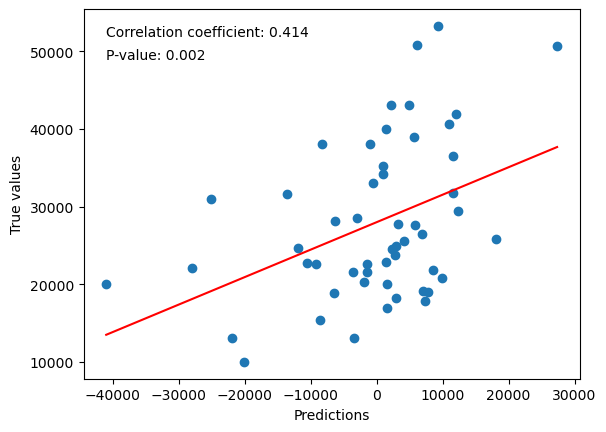

In [131]:
plt.scatter(predictions,mvc)
## plot the best fit line
model=LinearRegression()
model.fit(predictions.reshape(-1,1),mvc)
x=np.linspace(np.min(predictions),np.max(predictions),100)
y=model.predict(x.reshape(-1,1))
corcoeff=round(pearsonr(predictions,mvc)[0],3)
pval=round(pearsonr(predictions,mvc)[1],3)
plt.text(np.min(predictions),np.min(mvc)+42000,"Correlation coefficient: "+str(corcoeff))
plt.text(np.min(predictions),np.min(mvc)+39000,"P-value: "+str(pval))
plt.plot(x,y,color='red')
plt.xlabel("Predictions")
plt.ylabel("True values")

Text(0, 0.5, 'Correlation coefficient')

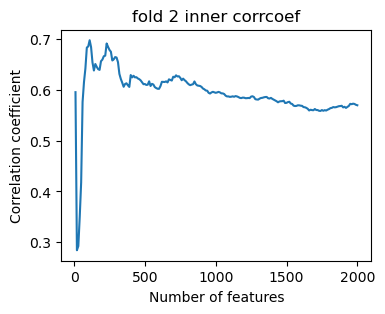

In [136]:
plt.figure(figsize=(4,3))
fol=2
plt.plot(num_features,inner_corrcoef[fol])
## draw a line on x=1600 red line
# plt.axvline(x=130,color='red')
## figure size
plt.title(f"fold {fol} inner corrcoef")
plt.xlabel("Number of features")
plt.ylabel("Correlation coefficient")


Text(0, 0.5, 'MVC values')

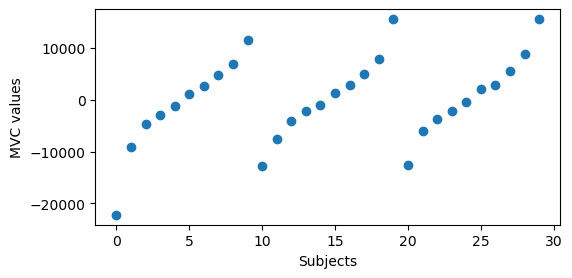

In [107]:
plt.figure(figsize=(6,2.8))
plt.scatter(np.arange(len(y_train_inner)),y_train_inner)
plt.xlabel("Subjects")
plt.ylabel("MVC values")